<a href="https://colab.research.google.com/github/sokhan1/PYTHON/blob/main/20240915_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#module

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.layers import Dense, Dropout

# Data Load

In [35]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Detect credit card anomalies/creditcard.csv'
data = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EDA

In [10]:
# data= data.astype(dtype='float32')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# Train, Test 분리

In [11]:
# 1. X, y 분리
X= data.iloc[:, :-1]
Y= data.iloc[:, -1]
# print(X) # Time~Amount
# print(Y) # Class

# 2. train, test 분리
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)

for train_index, test_index in kfold.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

print(X_train.shape, y_train.shape) #(227846, 30) (227846,) 80%
print(X_test.shape, y_test.shape) #(56961, 30) (56961,) 20%
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

(227846, 30) (227846,)
(56961, 30) (56961,)


# Train, Test 시각화

In [12]:
import seaborn as sns
sns.scatterplot(X_train)
plt.show()

KeyboardInterrupt: 

# Hyperparameter

## learning_rate_decay 변경
    exponential -> cosine -> inverse


In [19]:
# 1. 학습률
# 초기값 설정
initial_learning_rate = 0.01
decay_steps = 5
decay_rate = 0.95
epochs = np.arange(1, 101)

# Exponential Decay
exponential_decay = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=decay_steps, decay_rate=decay_rate
)

# 2. 배치크기
batch_size = 2**12 #13만 #train 데이터의 약 50%크기

100


## Learning Rate Decay Visualization

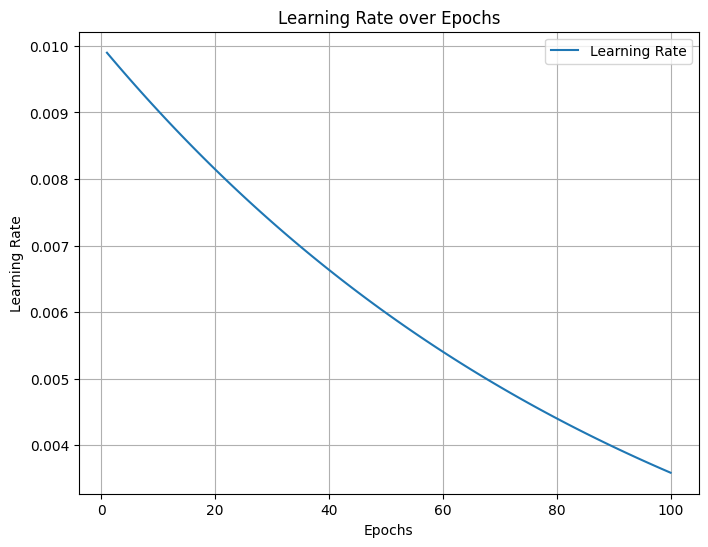

In [14]:
# Exponential Decay 체크
learning_rate_check = []
for epoch in epochs:
    learning_rate = exponential_decay(epoch)
    learning_rate_check.append(learning_rate.numpy())

# 학습율 시각화
plt.figure(figsize=(8, 6))
plt.plot(epochs, learning_rate_check, label='Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# model 구축

## 가중치 초기화

In [15]:
print(X_train.shape[1])

30


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

model = Sequential()

#가중치 초기화
weight_init = tf.keras.initializers.he_uniform()
# weight_init = tf.keras.initializaers.RandomNormal()
# weight_init = tf.keras.initializaers.glorot_uniform()

#model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu', input_dim=30, kernel_initializer=weight_init))  # 첫 번째 은닉층
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))  # 두 번째 은닉층
model.add(Dropout(0.5))  # 50% 드롭아웃 적용
model.add(Dense(32, activation='relu'))  # 세 번째 은닉층
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 128)                 │           3,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,337 (56.00 KB)

 Trainable params: 14,337 (56.00 KB)

 Non-trainable params: 0 (0.00 B)

# 최적화

In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=exponential_decay),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Training

In [39]:
#생성된 데이터를 batch_size로 나누어, epoch만큼 학습시킴
history = model.fit(X_train, y_train, epochs=len(epochs), validation_data=(X_train, y_train), batch_size = batch_size)

Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9953 - loss: 92.7046 - val_accuracy: 0.9983 - val_loss: 0.8363
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9972 - loss: 4.1797 - val_accuracy: 0.9983 - val_loss: 0.2236
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9970 - loss: 1.7974 - val_accuracy: 0.9983 - val_loss: 0.1443
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9970 - loss: 1.1333 - val_accuracy: 0.9983 - val_loss: 0.1639
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9969 - loss: 0.8520 - val_accuracy: 0.9983 - val_loss: 0.1784
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9973 - loss: 0.6344 - val_accuracy: 0.9983 - val_loss: 0.1573
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9973 - loss: 0.5494 - val_accuracy: 0.9983 - val_loss: 0.1282
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9972 - loss: 0.6016 - val_accuracy: 0.9983 -

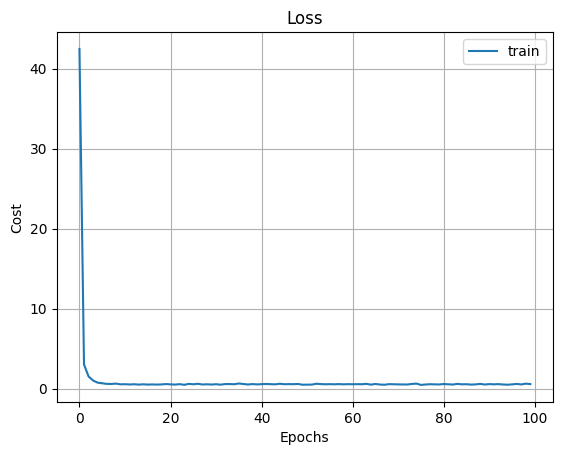

In [40]:
plt.plot(history.history['loss'], label = "train")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title('Loss')
plt.grid()
plt.legend()
plt.show()

# Model Evaluation

In [29]:
eval_loss, eval_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"evaluation_acc = {eval_acc}")
print(f"evaluation_loss = {eval_loss}")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9979 - loss: 0.5914
evaluation_acc = 0.9982795119285583
evaluation_loss = 0.5913294553756714


# Test

In [41]:
Prediction = model.predict(X_test)
print(Prediction)

print(Prediction[0])
print(y_test[0])

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
[[1.2306594e-11]
 [1.8663861e-01]
 [9.3206521e-03]
 ...
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]]
[1.2306594e-11]
0.0


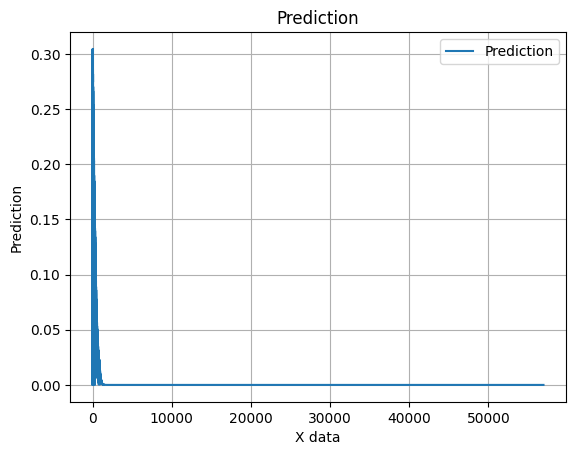

In [43]:
plt.plot(Prediction, label = "Prediction")
plt.xlabel("X data")
plt.ylabel("Prediction")
plt.title('Prediction')
plt.grid()
plt.legend()
plt.show()

# accuracy 검증


In [ ]:
# confusion_matrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

cnf_matrix = confusion_matrix(y_actual, y_pred, labels = ['cat', 'dog', 'rabbit'])
np.set_printoptions(precision = 2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes = ['cat', 'dog', 'rabbit'], title = 'confusion matrix without normalization')
plt.show()

# 분류지표 계산
print(classification_report(y_train, y_train_pred))

# ROC(필요하면 쓰기)
from sklearn.metrics import roc_curve, auc
import pandas as pd

y_train_prob = lr.predict_proba(X_train)[:, 1]

fpr, tpr, threshold = roc_curve(y_train, y_train_prob)

a=pd.DataFrame()

a['fpr'] = 1-fpr
a['tpr'] = tpr
a['thres'] = threshold
# p(a)

import matplotlib.pyplot as plt

auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, label='auc: %.2f'%auc_score)
plt.show()

# Evaluation

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

# Visualization

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label = "train") #그래프모양 변경가능
plt.xlabel("Epochs") # 변수수정
plt.ylabel("Cost") #변수수정
plt.legend()
plt.show()